In [1]:
import torch
import tiktoken
from torch.utils.data import DataLoader

from previous_chapter import GPTModel
from previous_chapter import GPTConfig
from previous_chapter import  generate_text_simple

In [2]:
GPT_CONFIG_124M: GPTConfig = {
    "vocab_size": 50257,   # 어휘 사전 크기
    "context_length": 256, # 짧은 문맥 길이 (원본 길이: 1024)
    "emb_dim": 768,        # 임베딩 차원
    "n_heads": 12,         # 어텐션 헤드 개수
    "n_layers": 12,        # 층 개수
    "drop_rate": 0.1,      # 드롭아웃 비율
    "qkv_bias": False      # 쿼리-키-값 생성시 편향 사용 여부
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 추론 시에는 드롭아웃을 비활성화합니다

In [3]:
def text_to_token_ids(text: str, tokenizer: tiktoken.Encoding) -> torch.Tensor:
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 배치 차원 추가
    return encoded_tensor

def token_ids_to_text(token_ids: torch.Tensor, tokenizer: tiktoken.Encoding) -> str:
    flat = token_ids.squeeze(0) # 배치 차원 삭제
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [5]:
with torch.no_grad():
    logits = model(inputs)

print(logits.shape)
probas = torch.softmax(logits, dim=-1) # 어휘 사전의 각 토큰에 대한 확률
print(probas.shape) # 크기: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])
torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("토큰 ID:\n", token_ids)

토큰 ID:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(targets[0], tokenizer)}")
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

첫 번째 샘플의 타깃:  effort moves you
첫 번째 샘플의 타깃:  Armed heNetflix


In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # [2, 3, 50257]
print("텍스트 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("텍스트 2:", target_probas_2)

텍스트 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
텍스트 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [9]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [10]:
# 각 토큰에 대한 평균 확률을 계산합니다.
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [12]:
# 로짓의 크기는 (batch_size, num_tokens, vocab_size)입니다.
print("로짓 크기:", logits.shape)

# 타깃의 크기는 (batch_size, num_tokens)입니다.
print("타깃 크기:", targets.shape)

로짓 크기: torch.Size([2, 3, 50257])
타깃 크기: torch.Size([2, 3])


In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("펼친 로짓:", logits_flat.shape)
print("펼친 타깃:", targets_flat.shape)

펼친 로짓: torch.Size([6, 50257])
펼친 타깃: torch.Size([6])


In [14]:
from data import fetch_text_data

text_data = fetch_text_data()

In [15]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [16]:
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [17]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("문자:", total_characters)
print("토큰:", total_tokens)

문자: 20479
토큰: 5145


In [18]:
from previous_chapter import create_dataloader_v1

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [19]:

print("훈련 데이터 로더:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n검증 데이터 로더:")
for x, y in val_loader:
    print(x.shape, y.shape)

훈련 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

검증 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])


In [20]:
def calc_loss_batch(
        input_batch: torch.Tensor,
        target_batch: torch.Tensor,
        model: GPTModel,
        device: torch.device
) -> torch.Tensor:
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(
        data_loader: torch.utils.data.DataLoader,
        model: GPTModel,
        device: torch.device,
        num_batches=None
) -> float:
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches



In [21]:
def determine_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        # 파이토치 2.9 이상에서는 mps 결과가 안정적입니다.
        major, minor = map(int, torch.__version__.split(".")[:2])
        if (major, minor) >= (2, 9):
            return torch.device("mps")
        else:
            return torch.device("cpu")
    else:
        return torch.device("cpu")

device = determine_device()
print(f"Using {device} device.")

Using mps device.


In [22]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("훈련 손실:", train_loss)
print("검증 손실:", val_loss)

훈련 손실: 10.987582948472765
검증 손실: 10.98110580444336


In [26]:
def train_model_simple(
        model: GPTModel,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        num_epochs: int,
        eval_freq: int,
        eval_iter: int,
        start_context: str,
        tokenizer: tiktoken.Encoding
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen = input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"epoch: {epoch}, step: {global_step}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model: GPTModel, train_loader: DataLoader, val_loader: DataLoader, device: torch.device, eval_iter: int) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model: GPTModel, tokenizer: tiktoken.Encoding, device: torch.device, start_context: str):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [27]:
torch.manual_seed(123)
print(f"device: {device}")

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

num_epochs = 100
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

device: mps
epoch: 0, step: 0, train loss: 10.9189, val loss: 10.9062
epoch: 0, step: 5, train loss: 10.4927, val loss: 10.5773
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
epoch: 1, step: 10, train loss: 10.1195, val loss: 10.2766
epoch: 1, step: 15, train loss: 9.8119, val loss: 9.9815
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
epoch: 2, step: 20, train loss: 9.5506, val loss: 9.7125
epoch: 2, step: 25, train loss: 9.2953, val loss: 9.4963
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
epoch: 3, step: 30, train loss: 9.1150, val loss: 9.3113
epoch: 3, step: 35, train loss: 8.9808, val loss: 9.1539
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
epoch: 4, step: 40, train loss: 8.8064, val loss: 9.0100
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
epoch: 5, step: 45, train loss: 8.7022, val loss: 8.8655
epoch: 5, step: 50, train loss: 8.5504, val loss:

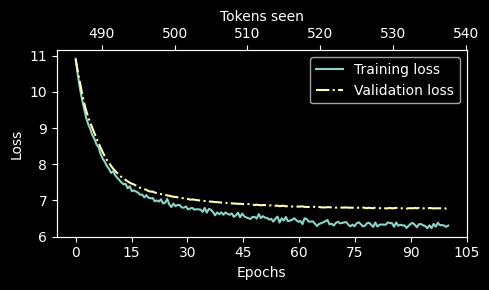

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 에포크에 대한 훈련 손실과 검증 손실의 그래프를 그립니다.
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # 처리한 토큰 수에 대한 두 번째 x 축을 만듭니다.
    ax2 = ax1.twiny()  # y 축을 공유하는 두 번째 x 축을 만듭니다.
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 눈금을 정렬하기 위해 투명한 그래프를 만듭니다.
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [29]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you, and, and, the, and, and, and, and.










